In [1]:
# Import modules
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import datetime
import csv
import requests
import pandas_datareader.data as web
import pandas_datareader as pdr
from pandas_datareader import data, wb

QUANDL_API_KEY= str(np.loadtxt('quandl_key.txt', dtype='str'))

import quandl
quandl.ApiConfig.api_key = QUANDL_API_KEY
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.signal import detrend
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import fbprophet

%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

In [51]:
def getstockdata(stock_name):
    stock_ind = stocks[stocks['Name'] == stock_name]
    y = stock_ind['y'].values
    ds = stock_ind['ds']
    return y, ds 

def getstock(stock_name):
    stock_ind = stocks[stocks['Name'] == stock_name]
    return stock_ind

In [4]:
# Analyze stock data 
# based off of the following sources:
    # https://medium.com/@rohanjoseph_91119/stock-analysis-in-python-4e7b7884517a
    # https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/

# tickers = ['AAPL', 'MSFT', 'GOOGL', 'GM', 'TSLA', 'AMZN', 'KO', 'T', 'INTC', 'BMO', 'SLF', 'RY', 'CM'] 
# tickers: '^GSPC', '^DJI', '^IXIC': S&P500, Dow Jones, Nasdaq
stock_list = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2004-01-01'
end_date = '2019-01-20'

# get data

stocks = pd.DataFrame()
stock_names = []

for i in range(len(stock_list)):
    print("Downloading data for", stock_list[i])
    stock = data.DataReader(stock_list[i], 'yahoo', start_date, end_date)
    stock_names.append(stock_list[i])
    stock['Name']=stock_list[i]
    ds = stock.index
    stocks = pd.DataFrame.append(stocks,stock)

stocks.reset_index(level=0, inplace = True)
stocks = stocks.rename(columns={'Date': 'ds', 'Adj Close': 'y'})

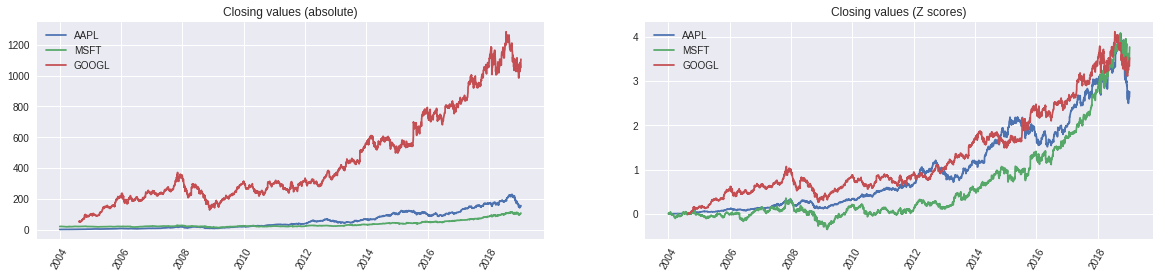

In [10]:
#Plot stock trends for selected stocks

# first plot raw data
plt.figure(figsize=(20,4)); 
plt.subplot(121)
leglabels = []
for i in range(len(stock_names)):
    stock_ind = stocks[stocks['Name'] == stock_names[i]]
    y = stock_ind['y']
    ds = stock_ind['ds']
    y_dt = detrend(y, axis=0, type='linear')
    plt.plot(ds, y)
    #plt.plot(np.array([y, y_dt]).T); #plt.legend(stock_names[i])
    plt.xticks(rotation=60)
plt.legend(stock_names)
plt.title('Closing values (absolute)')

# add 2nd plot with z-scores
plt.subplot(122) 
for i in range(len(stock_names)):
    stock_ind = stocks[stocks['Name'] == stock_names[i]]
    y = stock_ind['y']
    ds = stock_ind['ds']
    yy = pd.Series(y).pct_change()
    #y = yy.values; y[0] = 0
    y = zscore(y); y = y - y[0] # subtract first value so that initial point is 0 for all stocks; easier to compare
    plt.plot(ds,y); #plt.legend(stock_names[i])
    plt.xticks(rotation=60)
plt.legend(stock_names)
plt.title('Closing values (Z scores)')
plt.show()

In [38]:
# modeling with Prophet
stock = getstock('AAPL')
stock_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
stock_prophet.fit(stock)

# Make a future dataframe for 2 years
stock_forecast_df = stock_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
stock_forecast = stock_prophet.predict(stock_forecast_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


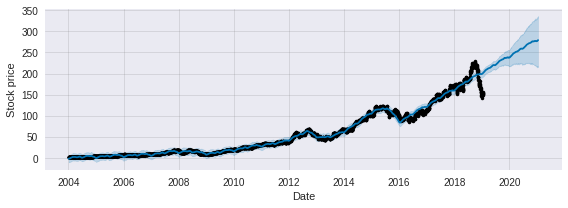

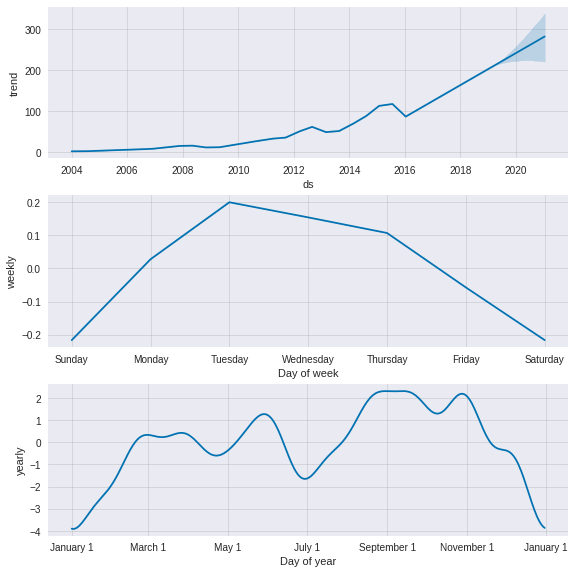

In [39]:
# plots
fig, ax = plt.subplots(figsize=(8,3))
stock_prophet.plot(stock_forecast, xlabel = 'Date', ylabel = 'Stock price', ax=ax)
fig2 = stock_prophet.plot_components(stock_forecast)
fig2.set_size_inches(8,8)

In [40]:
# custom model

custom_model = fbprophet.Prophet(weekly_seasonality=False,yearly_seasonality=True)
custom_model.add_seasonality('self_define_cycle',period=4,fourier_order=4,mode='additive')
custom_model.fit(stock)
custom_stock_forecast_df = custom_model.make_future_dataframe(periods=365 * 2, freq='D')
custom_stock_forecast = custom_model.predict(custom_stock_forecast_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


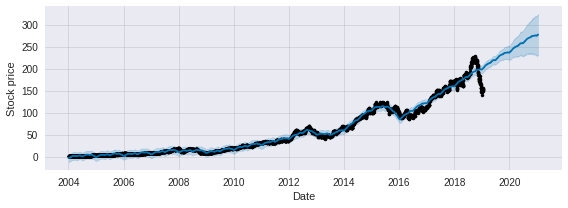

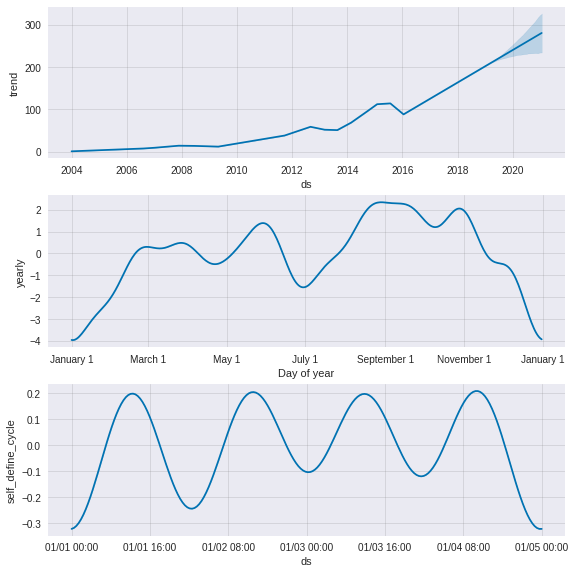

In [41]:
# plots
fig, ax = plt.subplots(figsize=(8,3))
m.plot(custom_stock_forecast, xlabel = 'Date', ylabel = 'Stock price', ax=ax)
fig2 = custom_model.plot_components(custom_stock_forecast)
fig2.set_size_inches(8,8)

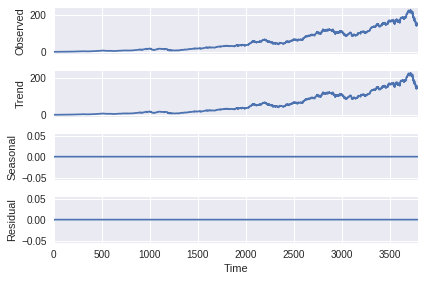

In [52]:
# seasonal decompose

y,ds = getstockdata('AAPL')
result = seasonal_decompose(y, model='additive', freq=1)
result.plot()
plt.show()

(3788,)
(3788,)


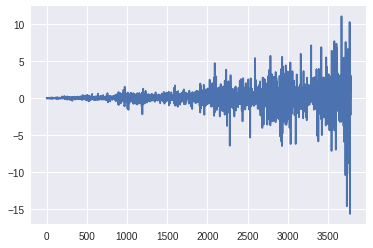

In [56]:
# differencing

y,ds = getstockdata('AAPL')
print(y.shape)
print(ds.shape)
diffs = []
for i in range(1, len(y)):
    diff = y[i] - y[i - 1]
    diffs.append(diff)
plt.plot(diffs)
plt.show()

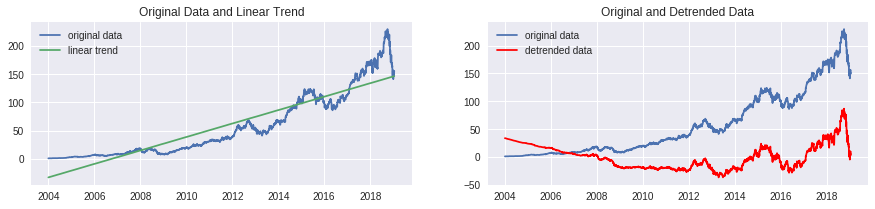

In [69]:
# detrending 

y,ds = getstockdata('AAPL')
y_dt = detrend(y, axis=0, type='linear')
X = np.arange(0,len(y)).reshape([-1,1])
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# detrend
detrended = [y[i]-trend[i] for i in range(0, len(y))]

# plots
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(ds,y,label='original data')
plt.plot(ds,trend, label='linear trend')
plt.legend()
plt.title('Original Data and Linear Trend')
plt.subplot(122)
plt.plot(ds,y, label='original data')
plt.plot(ds,detrended, c='r', label='detrended data')
plt.legend()
plt.title('Original and Detrended Data')
plt.show()